In [63]:
import os
import random
from collections import Counter
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset,random_split,SubsetRandomSampler, WeightedRandomSampler
from tqdm import tqdm
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [64]:
from matplotlib import pyplot as plt

In [65]:
def seed_everything(seed=3407): # The torch.manual_seed(3407) is all you need! xD
    """
    Seed everything to make all operations in PyTorch (and other libraries) deterministic.
    Args:
        seed (int): Seed value to set.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [66]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x_cont = torch.tensor(self.dataframe.iloc[idx]['X_cont'], dtype=torch.float32)

        other_cols = self.dataframe.drop(columns=['label', 'X_cont','Unit1'])
        x_other = torch.tensor(other_cols.iloc[idx].values, dtype=torch.float32)

        label = torch.tensor(self.dataframe.iloc[idx]['label'], dtype=torch.long)
        
        return x_cont, x_other, label

In [67]:
class BayesianLSTM(nn.Module):
    def __init__(self, dyn_channels=5, stat_channels=32, hidden_size=50, num_layers=2):
        super(BayesianLSTM, self).__init__()
        # lstm part
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(dyn_channels, hidden_size, num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, 15)
        
        # fc part
        self.fc_static1 = nn.Linear(stat_channels,30)
        self.fc_static2 = nn.Linear(30,15)
        
        # fusion part
        self.fc_final1 = nn.Linear(30,2)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x_dynamic, x_static):
        h0 = torch.zeros(self.num_layers, x_dynamic.size(0), self.hidden_size).to(x_dynamic.device)
        c0 = torch.zeros(self.num_layers, x_dynamic.size(0), self.hidden_size).to(x_dynamic.device)
        out1, _ = self.lstm(x_dynamic, (h0, c0))
        out1 = self.relu(self.fc1(out1[:, -1, :]))
        out1 = self.relu(self.fc2(out1))
        
        out2 = self.relu(self.fc_static1(x_static))
        out2 = self.relu(self.fc_static2(out2))
        
        out = torch.cat((out1, out2), dim=1)
        out = self.fc_final1(out)
        
        return out
device = 'cpu'
net = BayesianLSTM(dyn_channels=5, stat_channels=32, hidden_size=50, num_layers=2).to(device)
log_softmax = nn.LogSoftmax(dim=1)
def model(x_dynamic, x_static, y=None):
        # Define prior distributions for all neural network weights
        lstm_weightih0_prior = dist.Normal(loc=torch.zeros_like(net.lstm.weight_ih_l0), scale=5*torch.ones_like(net.lstm.weight_ih_l0)).to_event(2)
        lstm_biasih0_prior = dist.Normal(loc=torch.zeros_like(net.lstm.bias_ih_l0), scale=5*torch.ones_like(net.lstm.bias_ih_l0)).to_event(1)
        lstm_weightih1_prior = dist.Normal(loc=torch.zeros_like(net.lstm.weight_ih_l1), scale=5*torch.ones_like(net.lstm.weight_ih_l1)).to_event(2)
        lstm_biasih1_prior = dist.Normal(loc=torch.zeros_like(net.lstm.bias_ih_l1), scale=5*torch.ones_like(net.lstm.bias_ih_l1)).to_event(1)
        lstm_weighthh0_prior = dist.Normal(loc=torch.zeros_like(net.lstm.weight_hh_l0), scale=5*torch.ones_like(net.lstm.weight_hh_l0)).to_event(2)
        lstm_biashh0_prior = dist.Normal(loc=torch.zeros_like(net.lstm.bias_hh_l0), scale=5*torch.ones_like(net.lstm.bias_hh_l0)).to_event(1)
        lstm_weighthh1_prior = dist.Normal(loc=torch.zeros_like(net.lstm.weight_hh_l1), scale=5*torch.ones_like(net.lstm.weight_hh_l1)).to_event(2)
        lstm_biashh1_prior = dist.Normal(loc=torch.zeros_like(net.lstm.bias_hh_l1), scale=5*torch.ones_like(net.lstm.bias_hh_l1)).to_event(1)
        #lstm_weighthr0_prior = dist.Normal(loc=torch.zeros_like(self.lstm.weight_hr_l0), scale=torch.ones_like(self.lstm.weight_hr_l0))
        #lstm_biashr0_prior = dist.Normal(loc=torch.zeros_like(self.lstm.bias_hr_l0), scale=torch.ones_like(self.lstm.bias_hr_l0))
        #lstm_weighthr1_prior = dist.Normal(loc=torch.zeros_like(self.lstm.weight_hr_l1), scale=torch.ones_like(self.lstm.weight_hr_l1))
        #lstm_biashr1_prior = dist.Normal(loc=torch.zeros_like(self.lstm.bias_hr_l1), scale=torch.ones_like(self.lstm.bias_hr_l1))
        fc1w_prior = dist.Normal(loc=torch.zeros_like(net.fc1.weight), scale=5*torch.ones_like(net.fc1.weight)).to_event(2)
        fc1b_prior = dist.Normal(loc=torch.zeros_like(net.fc1.bias), scale=5*torch.ones_like(net.fc1.bias)).to_event(1)
        fc2w_prior = dist.Normal(loc=torch.zeros_like(net.fc2.weight), scale=5*torch.ones_like(net.fc2.weight)).to_event(2)
        fc2b_prior = dist.Normal(loc=torch.zeros_like(net.fc2.bias), scale=5*torch.ones_like(net.fc2.bias)).to_event(1)
        fc_static1w_prior = dist.Normal(loc=torch.zeros_like(net.fc_static1.weight), scale=5*torch.ones_like(net.fc_static1.weight)).to_event(2)
        fc_static1b_prior = dist.Normal(loc=torch.zeros_like(net.fc_static1.bias), scale=5*torch.ones_like(net.fc_static1.bias)).to_event(1)
        fc_static2w_prior = dist.Normal(loc=torch.zeros_like(net.fc_static2.weight), scale=5*torch.ones_like(net.fc_static2.weight)).to_event(2)
        fc_static2b_prior = dist.Normal(loc=torch.zeros_like(net.fc_static2.bias), scale=5*torch.ones_like(net.fc_static2.bias)).to_event(1)
        fc_final1w_prior = dist.Normal(loc=torch.zeros_like(net.fc_final1.weight), scale=5*torch.ones_like(net.fc_final1.weight)).to_event(2)
        fc_final1b_prior = dist.Normal(loc=torch.zeros_like(net.fc_final1.bias), scale=5*torch.ones_like(net.fc_final1.bias)).to_event(1)
        
        
        model_priors = {
            'lstm.weight_ih_l0': lstm_weightih0_prior, 'lstm.bias_ih_l0': lstm_biasih0_prior,
            'lstm.weight_ih_l1': lstm_weightih1_prior, 'lstm.bias_ih_l1': lstm_biasih1_prior,
            'lstm.weight_hh_l0': lstm_weighthh0_prior, 'lstm.bias_hh_l0': lstm_biashh0_prior,
            'lstm.weight_hh_l1': lstm_weighthh1_prior, 'lstm.bias_hh_l1': lstm_biashh1_prior,
            #'lstm.weight_hr_l0': lstm_weighthr0_prior, 'lstm.bias_hr_l0': lstm_biashr0_prior,
            #'lstm.weight_hr_l1': lstm_weighthr1_prior, 'lstm.bias_hr_l1': lstm_biashr1_prior,
            'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,
            'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior,
            'fc_static1.weight': fc_static1w_prior, 'fc_static1.bias': fc_static1b_prior,
            'fc_static2.weight': fc_static2w_prior, 'fc_static2.bias': fc_static2b_prior,
            #'fc_static3.weight': fc_static3w_prior, 'fc_static3.bias': fc_static3b_prior,
            'fc_final1.weight': fc_final1w_prior, 'fc_final1.bias': fc_final1b_prior,
            #'fc_final2.weight': fc_final2w_prior, 'fc_final2.bias': fc_final2b_prior
        }
        lifted_module = pyro.random_module("module", net, model_priors)  # Lift module parameters to random variables
        lifted_reg_model = lifted_module()
        #with pyro.plate("data", x_dynamic.size(0)):
        lhat = log_softmax(lifted_reg_model(x_dynamic, x_static))
        if y is not None:
                y = y.float()  
        pyro.sample("obs", dist.Categorical(logits=lhat).to_event(1), obs=y)
        return lhat
        

# Defining the guide function for variational inference
softplus = torch.nn.Softplus()
def guide(x_dynamic, x_static, y=None):
        # Define variational distributions for the parameters (learnable)
        #softplus = torch.nn.Softplus()
        lstm_weightih0_mu = torch.randn_like(net.lstm.weight_ih_l0)
        lstm_weightih0_sigma = torch.randn_like(net.lstm.weight_ih_l0)
        lstm_weightih0_mu_param = pyro.param("lstm_weightih0_mu", lstm_weightih0_mu)
        lstm_weightih0_sigma_param = softplus(pyro.param("lstm_weightih0_sigma", lstm_weightih0_sigma))
        lstm_weightih0_prior = dist.Normal(loc=lstm_weightih0_mu_param, scale=lstm_weightih0_sigma_param).to_event(2)
        lstm_biasih0_mu = torch.randn_like(net.lstm.bias_ih_l0)
        lstm_biasih0_sigma = torch.randn_like(net.lstm.bias_ih_l0)
        lstm_biasih0_mu_param = pyro.param("lstm_biasih0_mu", lstm_biasih0_mu)
        lstm_biasih0_sigma_param = softplus(pyro.param("lstm_biasih0_sigma", lstm_biasih0_sigma))
        lstm_biasih0_prior = dist.Normal(loc=lstm_biasih0_mu_param, scale=lstm_biasih0_sigma_param).to_event(1)

        lstm_weightih1_mu = torch.randn_like(net.lstm.weight_ih_l1)
        lstm_weightih1_sigma = torch.randn_like(net.lstm.weight_ih_l1)
        lstm_weightih1_mu_param = pyro.param("lstm_weightih1_mu", lstm_weightih1_mu)
        lstm_weightih1_sigma_param = softplus(pyro.param("lstm_weightih1_sigma", lstm_weightih1_sigma))
        lstm_weightih1_prior = dist.Normal(loc=lstm_weightih1_mu_param, scale=lstm_weightih1_sigma_param).to_event(2)
        lstm_biasih1_mu = torch.randn_like(net.lstm.bias_ih_l1)
        lstm_biasih1_sigma = torch.randn_like(net.lstm.bias_ih_l1)
        lstm_biasih1_mu_param = pyro.param("lstm_biasih1_mu", lstm_biasih1_mu)
        lstm_biasih1_sigma_param = softplus(pyro.param("lstm_biasih1_sigma", lstm_biasih1_sigma))
        lstm_biasih1_prior = dist.Normal(loc=lstm_biasih1_mu_param, scale=lstm_biasih1_sigma_param).to_event(1)

        lstm_weighthh0_mu = torch.randn_like(net.lstm.weight_hh_l0)
        lstm_weighthh0_sigma = torch.randn_like(net.lstm.weight_hh_l0)
        lstm_weighthh0_mu_param = pyro.param("lstm_weighthh0_mu", lstm_weighthh0_mu)
        lstm_weighthh0_sigma_param = softplus(pyro.param("lstm_weighthh0_sigma", lstm_weighthh0_sigma))
        lstm_weighthh0_prior = dist.Normal(loc=lstm_weighthh0_mu_param, scale=lstm_weighthh0_sigma_param).to_event(2)
        lstm_biashh0_mu = torch.randn_like(net.lstm.bias_hh_l0)
        lstm_biashh0_sigma = torch.randn_like(net.lstm.bias_hh_l0)
        lstm_biashh0_mu_param = pyro.param("lstm_biashh0_mu", lstm_biashh0_mu)
        lstm_biashh0_sigma_param = softplus(pyro.param("lstm_biashh0_sigma", lstm_biashh0_sigma))
        lstm_biashh0_prior = dist.Normal(loc=lstm_biashh0_mu_param, scale=lstm_biashh0_sigma_param).to_event(1)

        lstm_weighthh1_mu = torch.randn_like(net.lstm.weight_hh_l1)
        lstm_weighthh1_sigma = torch.randn_like(net.lstm.weight_hh_l1)
        lstm_weighthh1_mu_param = pyro.param("lstm_weighthh1_mu", lstm_weighthh1_mu)
        lstm_weighthh1_sigma_param = softplus(pyro.param("lstm_weighthh1_sigma", lstm_weighthh1_sigma))
        lstm_weighthh1_prior = dist.Normal(loc=lstm_weighthh1_mu_param, scale=lstm_weighthh1_sigma_param).to_event(2)
        lstm_biashh1_mu = torch.randn_like(net.lstm.bias_hh_l1)
        lstm_biashh1_sigma = torch.randn_like(net.lstm.bias_hh_l1)
        lstm_biashh1_mu_param = pyro.param("lstm_biashh1_mu", lstm_biashh1_mu)
        lstm_biashh1_sigma_param = softplus(pyro.param("lstm_biashh1_sigma", lstm_biashh1_sigma))
        lstm_biashh1_prior = dist.Normal(loc=lstm_biashh1_mu_param, scale=lstm_biashh1_sigma_param).to_event(1)
        
        fc1w_mu = torch.randn_like(net.fc1.weight)
        fc1w_sigma = torch.randn_like(net.fc1.weight)
        fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
        fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
        fc1w_prior = dist.Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param).to_event(2)
        fc1b_mu = torch.randn_like(net.fc1.bias)
        fc1b_sigma = torch.randn_like(net.fc1.bias)
        fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
        fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
        fc1b_prior = dist.Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param).to_event(1)

        fc2w_mu = torch.randn_like(net.fc2.weight)
        fc2w_sigma = torch.randn_like(net.fc2.weight)
        fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
        fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
        fc2w_prior = dist.Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param).to_event(2)
        fc2b_mu = torch.randn_like(net.fc2.bias)
        fc2b_sigma = torch.randn_like(net.fc2.bias)
        fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
        fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
        fc2b_prior = dist.Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param).to_event(1)

        fc_static1w_mu = torch.randn_like(net.fc_static1.weight)
        fc_static1w_sigma = torch.randn_like(net.fc_static1.weight)
        fc_static1w_mu_param = pyro.param("fc_static1w_mu", fc_static1w_mu)
        fc_static1w_sigma_param = softplus(pyro.param("fc_static1w_sigma", fc_static1w_sigma))
        fc_static1w_prior = dist.Normal(loc=fc_static1w_mu_param, scale=fc_static1w_sigma_param).to_event(2)
        fc_static1b_mu = torch.randn_like(net.fc_static1.bias)
        fc_static1b_sigma = torch.randn_like(net.fc_static1.bias)
        fc_static1b_mu_param = pyro.param("fc_static1b_mu", fc_static1b_mu)
        fc_static1b_sigma_param = softplus(pyro.param("fc_static1b_sigma", fc_static1b_sigma))
        fc_static1b_prior = dist.Normal(loc=fc_static1b_mu_param, scale=fc_static1b_sigma_param).to_event(1)

        fc_static2w_mu = torch.randn_like(net.fc_static2.weight)
        fc_static2w_sigma = torch.randn_like(net.fc_static2.weight)
        fc_static2w_mu_param = pyro.param("fc_static2w_mu", fc_static2w_mu)
        fc_static2w_sigma_param = softplus(pyro.param("fc_static2w_sigma", fc_static2w_sigma))
        fc_static2w_prior = dist.Normal(loc=fc_static2w_mu_param, scale=fc_static2w_sigma_param).to_event(2)
        fc_static2b_mu = torch.randn_like(net.fc_static2.bias)
        fc_static2b_sigma = torch.randn_like(net.fc_static2.bias)
        fc_static2b_mu_param = pyro.param("fc_static2b_mu", fc_static2b_mu)
        fc_static2b_sigma_param = softplus(pyro.param("fc_static2b_sigma", fc_static2b_sigma))
        fc_static2b_prior = dist.Normal(loc=fc_static2b_mu_param, scale=fc_static2b_sigma_param).to_event(1)
        

        fc_final1w_mu = torch.randn_like(net.fc_final1.weight)
        fc_final1w_sigma = torch.randn_like(net.fc_final1.weight)
        fc_final1w_mu_param = pyro.param("fc_final1w_mu", fc_final1w_mu)
        fc_final1w_sigma_param = softplus(pyro.param("fc_final1w_sigma", fc_final1w_sigma))
        fc_final1w_prior = dist.Normal(loc=fc_final1w_mu_param, scale=fc_final1w_sigma_param).to_event(2)
        fc_final1b_mu = torch.randn_like(net.fc_final1.bias)
        fc_final1b_sigma = torch.randn_like(net.fc_final1.bias)
        fc_final1b_mu_param = pyro.param("fc_final1b_mu", fc_final1b_mu)
        fc_final1b_sigma_param = softplus(pyro.param("fc_final1b_sigma", fc_final1b_sigma))
        fc_final1b_prior = dist.Normal(loc=fc_final1b_mu_param, scale=fc_final1b_sigma_param).to_event(1)
        
        guide_priors = {'lstm.weight_ih_l0': lstm_weightih0_prior, 'lstm.bias_ih_l0': lstm_biasih0_prior,'lstm.weight_ih_l1': lstm_weightih1_prior, 'lstm.bias_ih_l1': lstm_biasih1_prior,
                    'lstm.weight_hh_l0': lstm_weighthh0_prior, 'lstm.bias_hh_l0': lstm_biashh0_prior,'lstm.weight_hh_l1': lstm_weighthh1_prior, 'lstm.bias_hh_l1': lstm_biashh1_prior,
                    #'lstm.weight_hr_l0': lstm_weighthr0_prior, 'lstm.bias_hr_l0': lstm_biashr0_prior,'lstm.weight_hr_l1': lstm_weighthr1_prior, 'lstm.bias_hr_l1': lstm_biashr1_prior,
                    'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior, 'fc_static1.weight': fc_static1w_prior, 'fc_static1.bias': fc_static1b_prior,'fc_static2.weight': fc_static2w_prior, 'fc_static2.bias': fc_static2b_prior,
                    'fc_final1.weight': fc_final1w_prior, 'fc_final1.bias': fc_final1b_prior}
        lifted_module = pyro.random_module("module", net, guide_priors)  # Lift module parameters to random variables
        return lifted_module()

In [68]:
trainval_df = pd.read_pickle('train.pkl').reset_index(drop=True)
        
class_0 = trainval_df[trainval_df['label'] == 0]
class_1 = trainval_df[trainval_df['label'] == 1]
n_samples = len(class_1) 
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
train_df = df_balanced.reset_index(drop=True)
      
N = len(train_df)
train_df = train_df.sample(frac=1).reset_index(drop=True)
val = train_df[:int(N*0.2)]
train_df = train_df[int(N*0.2):]
train_df.fillna(value=np.pi, inplace=True)
val.fillna(value=np.pi, inplace=True)

In [69]:
print(train_df.shape)
print(val.shape)

(28245, 35)
(7061, 35)


In [70]:
train_dataset = SequenceDataset(train_df)
valid_dataset = SequenceDataset(val)
train_num = len(train_dataset)
val_num = len(valid_dataset)
batch_size=20
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
    
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw, drop_last=True)

print("using {} samples for training, {} samples for validation.".format(train_num,
                                                                           val_num))

Using 8 dataloader workers every process
using 28245 samples for training, 7061 samples for validation.


In [71]:
sample = train_dataset[0]
print(sample[0].shape)
print(sample[1].shape)
print(sample[2])
for x_dynamic, x_static, y in train_loader:
    print(x_dynamic.shape)
    print(x_static.shape)
    print(y.shape)
    break

torch.Size([10, 5])
torch.Size([32])
tensor(0)
torch.Size([20, 10, 5])
torch.Size([20, 32])
torch.Size([20])


In [72]:
num_samples = 5

def predict(x_dynamic, x_static):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x_dynamic, x_static).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    #print(mean.numpy())
    return np.argmax(mean.numpy(), axis=1)#(mean > 0.5).float().reshape(-1)'''
'''
from pyro.infer import Predictive
def predict(x_dynamic, x_static, model, guide, num_samples=100):
    predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=["obs", "_RETURN"])
    svi_samples = predictive(x_dynamic, x_static)
    #print(svi_samples)
    if '_RETURN' in svi_samples:
        predictions = torch.stack([svi_samples['_RETURN'][i] for i in range(num_samples)])
    else:
        predictions = torch.stack([svi_samples['obs'][i].float() for i in range(num_samples)])
    predicted_probabilities = torch.mean(predictions, dim=0)
    predicted_labels = predicted_probabilities.argmax(dim=-1)
    return predicted_labels'''

'\nfrom pyro.infer import Predictive\ndef predict(x_dynamic, x_static, model, guide, num_samples=100):\n    predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=["obs", "_RETURN"])\n    svi_samples = predictive(x_dynamic, x_static)\n    #print(svi_samples)\n    if \'_RETURN\' in svi_samples:\n        predictions = torch.stack([svi_samples[\'_RETURN\'][i] for i in range(num_samples)])\n    else:\n        predictions = torch.stack([svi_samples[\'obs\'][i].float() for i in range(num_samples)])\n    predicted_probabilities = torch.mean(predictions, dim=0)\n    predicted_labels = predicted_probabilities.argmax(dim=-1)\n    return predicted_labels'

In [73]:
def train(model, guide, train_loader, valid_loader, num_epochs=30):
    
    optim = Adam({"lr":1e-3})
    svi = SVI(model, guide, optim, loss=Trace_ELBO())
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    #model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total_train = 0
        for x_dynamic, x_static, y in train_loader:
            
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            #print(x_dynamic.shape)
            loss = svi.step(x_dynamic, x_static, y)
            total_loss += loss
            
            with torch.no_grad():
                #lifted_module = model.guide(x_dynamic, x_static, y)
                pred_label = predict(x_dynamic, x_static)
                #print(f"the prediction prob is:{pred.reshape(-1)}")
                #pred = torch.sigmoid(pred)
            #pred_label = (pred > 0.5).float()
            #print(type(pred_label))
            correct += (pred_label.reshape(-1) == y.numpy().reshape(-1)).astype(int).sum().item()
            total_train += y.shape[0]
            #print(pred_label.reshape(-1))
            #print(y.shape[0])
        epoch_loss = total_loss / total_train
        epoch_accuracy = correct / total_train
        train_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}")
        train_loss_list.append(epoch_loss)

        total_loss = 0
        correct = 0
        total = 0
        for x_dynamic, x_static, y_val in valid_loader:
            #model.eval()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y_val = y_val.cuda()
            with torch.no_grad():
                loss = svi.evaluate_loss(x_dynamic, x_static, y_val)
                total_loss += loss
                #lifted_module = model.guide(x_dynamic, x_static, y)
                pred_label = predict(x_dynamic, x_static)
                #print(pred)
                #pred = torch.sigmoid(pred)
                #pred_label = (pred > 0.5).float()
                total += y_val.shape[0]
                correct += (pred_label.reshape(-1) == y_val.numpy().reshape(-1)).astype(int).sum().item()
             
            epoch_loss = total_loss / total
        epoch_accuracy = correct / total
        valid_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss}, Validation Accuracy: {epoch_accuracy}")
        valid_loss_list.append(epoch_loss)
    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [74]:
print(len(train_loader))

1412


In [75]:
#net = BayesianLSTM(dyn_channels=5, stat_channels=32, hidden_size=50, num_layers=2)
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(model, guide, train_loader, valid_loader, num_epochs=30)

/Users/zhaoxiuheng/anaconda3/envs/course/lib/python3.7/site-packages/pyro/primitives.py:495: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  FutureWarning,


Epoch 1, Train Loss: 96.13071179601019, Train Accuracy: 0.504143059490085
Epoch 1, Validation Loss: 83.24833237429179, Validation Accuracy: 0.5058073654390934
Epoch 2, Train Loss: 78.63019845617391, Train Accuracy: 0.5029390934844192
Epoch 2, Validation Loss: 67.0375497963881, Validation Accuracy: 0.5104815864022663
Epoch 3, Train Loss: 62.10277487443122, Train Accuracy: 0.5049575070821529
Epoch 3, Validation Loss: 55.81212044086402, Validation Accuracy: 0.506657223796034
Epoch 4, Train Loss: 53.67342505568148, Train Accuracy: 0.5084985835694051
Epoch 4, Validation Loss: 47.39237008675637, Validation Accuracy: 0.4998583569405099
Epoch 5, Train Loss: 45.523496897649494, Train Accuracy: 0.5021246458923513
Epoch 5, Validation Loss: 42.82246481055241, Validation Accuracy: 0.49773371104815867
Epoch 6, Train Loss: 39.84612436709931, Train Accuracy: 0.5038597733711048
Epoch 6, Validation Loss: 39.59890447946176, Validation Accuracy: 0.4934844192634561
Epoch 7, Train Loss: 36.288999712450305, 

Text(0.5, 1.0, 'Accuracy curve')

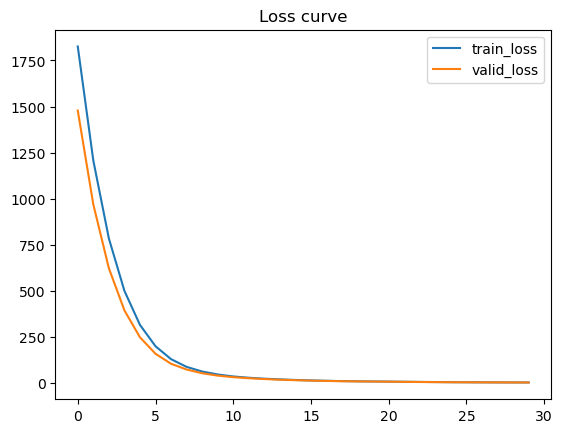

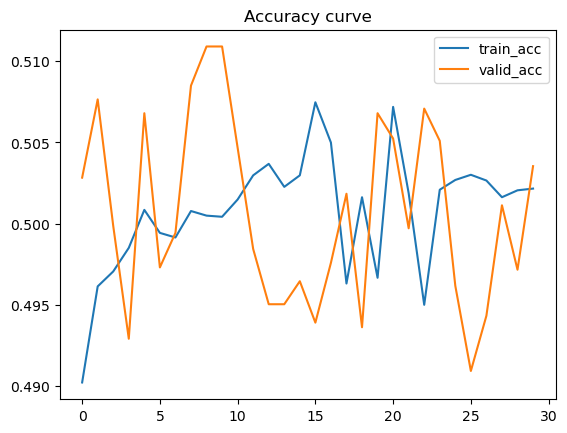

In [ ]:
plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(valid_loss_list, label="valid_loss")
plt.legend()
plt.title(f"Loss curve")

plt.figure()
plt.plot(train_acc_list, label="train_acc")
plt.plot(valid_acc_list, label="valid_acc")
plt.legend()
plt.title(f"Accuracy curve")

In [ ]:
batch_size=20
test_df = pd.read_pickle('test.pkl').reset_index(drop=True)
        
class_0 = test_df[test_df['label'] == 0]
class_1 = test_df[test_df['label'] == 1]
n_samples = len(class_1) 
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
test_df = df_balanced.reset_index(drop=True)
      
N = len(test_df)
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df.fillna(value=np.pi, inplace=True)
test_dataset = SequenceDataset(test_df)
test_num = len(test_dataset)

    
test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = False)

In [ ]:
correct = 0
total = 0
y_true=[]
y_pred=[]
for x_dynamic, x_static, y in test_loader:
            
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            y = y.float()
            
            lifted_module = model.guide(x_dynamic, x_static, y)
            pred_label = predict(x_dynamic, x_static)
            total += y.shape[0]
            correct += (pred_label.reshape(-1) == y.numpy().reshape(-1)).astype(int).sum().item()
            y_true.append(y.reshape(-1))
            y_pred.append(pred_label.reshape(-1))

print(f"the test accuracy is {correct/total}")

/Users/zhaoxiuheng/anaconda3/envs/course/lib/python3.7/site-packages/pyro/primitives.py:495: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  FutureWarning,


AttributeError: 'bool' object has no attribute 'astype'

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import seaborn as sns
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
CM = confusion_matrix(y_true, y_pred)
#auc_score = roc_auc_score(y_true, y_prob_list, multi_class='ovr')
plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot=True, fmt="d", cmap='Blues')#, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'result/blstm.pth')

In [ ]:
for name, param in model.named_parameters():
    print(f"{name} has values: \n{param.data}")